In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import statistics

import scipy
import scipy.stats as stats
from scipy.stats import binom, poisson, gamma
from scipy.optimize import curve_fit, fsolve

import statsmodels.api as sm
from matplotlib import rcParams
import zipfile



In [2]:
cm = 1/2.54
fs = 11
flf = 10*cm
fhf = 10*cm
plt.rc('axes', labelsize=fs, titlesize=fs)
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('legend', fontsize=fs)
plt.rc('figure', figsize=(flf,fhf))
plt.rcParams['legend.title_fontsize'] = fs
plt.rcParams["legend.labelspacing"] = 0.25
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

riso=1000

## Functions

In [3]:
def bootstrap_ci(x0, repetitions = 1000, alpha = 0.05, fun=np.median):
    
    import numpy.random as nprm
    
    '''
    Compute the bootstrap confidence interval for a given statistic (median)

    Parameters:
        x0 (array-like): Input data.
        repetitions (int): Number of bootstrap samples (default 1000).
        alpha (float): Significance level (default 0.05 for 95% CI).
        fun (callable): Statistic function to apply (default np.median).

        
    Returns:
        lower_bound, upper_bound, bootstrap_statistics_array
    '''
    x1 = np.array(x0)
    bootstrap_sample_size = x1.size

    x_ci = np.zeros(repetitions)
    for i in range(repetitions):
        x = nprm.choice(x1, size=bootstrap_sample_size, replace=True)
        x_ci[i] = fun(x)
     
 
    left = np.percentile(x_ci, (alpha/2)*100)
    right = np.percentile(x_ci, (100-((alpha/2)*100)))
    

    
    return left, right, x_ci

In [4]:
def compute_error(num_pos, num_tested, z_score=1.96):
    """
    Compute the confidence interval for a proportion using a normal approximation.

    Parameters:
        num_pos (int): Number of positive outcomes.
        num_tested (int): Total number of trials.
        z_score (float): Z-score for desired confidence level (default 1.96 for ~95%).

    Returns:
        tuple: (lower_bound, upper_bound)
    """
    p = num_pos / num_tested
    error = z_score * math.sqrt((p *(1-p))/num_tested)
    LB = p - error
    UB = p + error
    return LB, UB

## Parameters

In [5]:
nsim = 2000
cod = [10001, 11010]
ims = 0.35
imt = 0.55
vxs = 0.0
vxt = 0.9
rbs = 0.35
rbt = 0.55
rbcs = 0.63
rbct = 1.00
sgs = 0.5
sgt = 1.0
pss = 0.80
pst = 0.5
pds = 0.3
pdt = 0.5
t = 1440
d = 7
#adh= 0.67
ntimes=[0,1]
nweeks=[0,1]

bw_val = 0.2

beta_mle = 0.0153

nnodes=232
model = {}
final_day=42

## Read data

In [6]:
# Read observed data
departments = ['Isere', 'Puy', 'Rhone', 'Savoie']

# Load total tests
with zipfile.ZipFile('data_in.zip') as z:
    with z.open('data_in/regular_tests_deps_w01-06.csv') as f:
        dfScreen_test = pd.read_csv(f, sep=';')
dfScreen_test['dep'] = departments

# Load positive tests
with zipfile.ZipFile('data_in.zip') as z:
    with z.open('data_in/regular_positive_deps_w01-06.csv') as f:
        dfScreen_pos = pd.read_csv(f, sep=';')
dfScreen_pos['dep'] = departments

weeks = ['W01', 'W02', 'W03', 'W04', 'W05', 'W06']
dfScreen_preva = pd.DataFrame(columns=['departments', 'W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'dep'])


dfScreen_preva['departments'] = dfScreen_pos['departments'].values
dfScreen_preva['dep'] = dfScreen_pos['dep'].values

# Compute the prevalence for each week and store it in the corresponding column
for week in weeks:
    dfScreen_preva[week] = (dfScreen_pos[week] / dfScreen_test[week]) * 100


In [7]:
## Read test sensitivity
with zipfile.ZipFile('data_in.zip') as z:
    with z.open('data_in/sensitivity-PCR.csv') as f:
        df = pd.read_csv(f)
dfSensitivity = df.copy()

theta_p = dfSensitivity[dfSensitivity['compartment']=='Ip'].PCR_symp_child.tolist()
theta_c = dfSensitivity[dfSensitivity['compartment']=='Ic'].PCR_symp_child.tolist()
theta_s = dfSensitivity[dfSensitivity['compartment']=='Ic'].PCR_asymp_child.tolist()
theta_r = dfSensitivity[dfSensitivity['compartment']=='Rp'].PCR_asymp_child.tolist()

#print('theta_p : ', theta_p)
#print('theta_c : ', theta_c)
#print('theta_s : ', theta_s)
#print('theta_r : ', theta_r)
#df

## Read sims

In [8]:
department = 'Rhone'

### Compute prevalence

In [11]:
# Color settings and protocol names
colors = ['#b8b8ff', '#287271']
protocol_names = {0: 'strengthened reactive screening', 1: 'weekly screening'}
alphas = [1, 0.5]
alphas_fill = [0.2, 0.2]

model_Rhone = {}


for idx, code in enumerate(cod):

    filename = (
        f"posit_n{nsim}_b{beta_mle:.4f}_{code}_im{ims:.2f}_{imt:.2f}_"
        f"Pd{pds:.1f}_{pdt:.1f}_t{t}_d{d}_f{ntimes[idx]}_{nweeks[idx]}.txt"
    )
    
    if idx == 0:
        with zipfile.ZipFile('data_out.zip') as z:
            with z.open('data_out/' + filename) as f:
                df = pd.read_csv(f, sep='\t', header=None)
    else:
        with zipfile.ZipFile('data_out_exp.zip') as z:
            with z.open('data_out/' + filename) as f:
                df = pd.read_csv(f, sep='\t', header=None)
   
    df.columns = [
        'sim', 'day', 'den', 'ip1', 'ip2', 'ip3', 'ip4',
        'ic1', 'ic2', 'ic3', 'ic4', 'ic5', 'ic6',
        'is1', 'is2', 'is3', 'is4', 'is5', 'is6',
        'ir1', 'ir2', 'ir3', 'ir4'
    ]
    
    
    df = df[df['day'] <= final_day]
    df['Ip'] = df['ip1'] * theta_p[0]
    df['Is'] = sum(df[f'is{i+1}'] * theta_s[i] for i in range(6))
    df['Ic'] = sum(df[f'ic{i+1}'] * theta_c[i] for i in range(6))
    df['Rp'] = sum(df[f'ir{i+1}'] * theta_r[i] for i in range(4))
    
    
    df['I'] = df['Ip'] + df['Is'] + df['Ic'] + df['Rp']
    
    
    df_infected = df.pivot(index='sim', columns='day', values='I')
    df_den = df.pivot(index='sim', columns='day', values='den')
    
   
    abs_weekly_prevalence = []
    pct_weekly_prevalence = []
    lower_bounds = []
    upper_bounds = []

    for day in range(0, final_day, 7):
        weekly_infected = df_infected[day]
        weekly_denominator = df_den[day]
        
        abs_prevalence = weekly_infected.median()
        pct_prevalence = (weekly_infected / weekly_denominator).median()
        
        abs_weekly_prevalence.append(abs_prevalence)
        pct_weekly_prevalence.append(pct_prevalence)
        
        wp = weekly_infected / weekly_denominator
        lower_bounds.append(wp.quantile(0.25) * 100)
        upper_bounds.append(wp.quantile(0.75) * 100)
    
    
    preva_table = pd.DataFrame({
        'week': np.arange(1, 7),
        'abs': abs_weekly_prevalence,
        'per': pct_weekly_prevalence,
        'up': upper_bounds,
        'dw': lower_bounds
    })

    
    model_Rhone[(beta_mle, code)] = preva_table

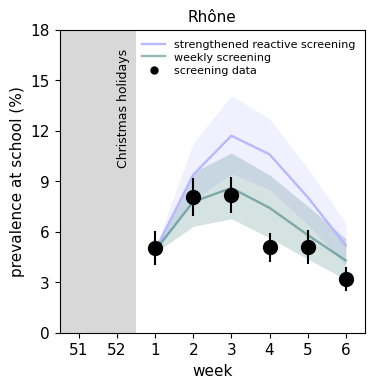

In [12]:
for idx, code in enumerate(cod):    
    
    m = model_Rhone[beta_mle, code]
    plt.plot(
        np.arange(len(m)),
        m['per'] * 100,
        lw=1.7,
        color=colors[idx],
        label=protocol_names[idx],
        alpha=alphas[idx],
        zorder=1
    )
    plt.fill_between(
        np.arange(len(m)),
        m['up'],
        m['dw'],
        color=colors[idx],
        alpha=alphas_fill[idx],
        linewidth=0,
        zorder=0
    )
    #print(m['per'] * 100, m['up'], m['dw'])

# Add observed data points

plt.scatter(
    np.arange(len(m)),
    dfScreen_preva[dfScreen_preva['dep'] == department][weeks].values[0],
    marker='o',
    s=100,
    color='black',
    zorder=2,
    label='screening data'
)

# Compute and plot error bars
LB, UB = [], []
for w in weeks:
    lb, ub = compute_error(
        dfScreen_pos[dfScreen_pos['dep'] == department][w].values[0],
        dfScreen_test[dfScreen_test['dep'] == department][w].values[0]
    )
    LB.append(lb * 100)
    UB.append(ub * 100)

plt.vlines(np.arange(len(m)), LB, UB, color='black')

# Extra plot formatting
plt.axvspan(-2.5, -0.5, facecolor='grey', zorder=-1, alpha=0.3)
plt.text(-1, 10, 'Christmas holidays', rotation='vertical', fontsize=9)
plt.title(dfScreen_preva[dfScreen_preva['dep'] == department]['departments'].values[0])
plt.ylabel('prevalence at school (%)')
plt.xlabel('week')
plt.ylim(0, 18)
plt.xlim(-2.5, 5.5)
plt.yticks(np.arange(0, 21, 3))
plt.xticks(np.arange(-2, len(preva_table)), labels=[51, 52, 1, 2, 3, 4, 5, 6])
plt.legend(frameon=False, fontsize=8, markerscale=0.5)
plt.show()

## Averted school transmission

averted school transmission: 37.18% (IQR: 29.49% – 44.87%)


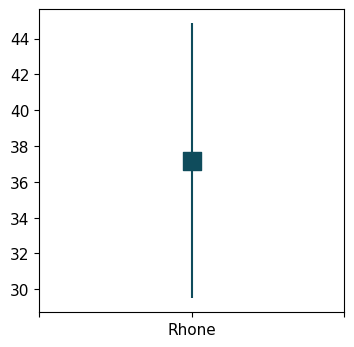

In [17]:
for idx, code in enumerate(cod):
    
    filename = (
        f"trasm_stn{nsim}_b{beta_mle:.4f}_{code}_im{ims:.2f}_{imt:.2f}_"
        f"Pd{pds:.1f}_{pdt:.1f}_t{t}_d{d}_f{ntimes[idx]}_{nweeks[idx]}.txt"
    )
    
    if idx == 0:
        with zipfile.ZipFile('data_out.zip') as z:
            with z.open('data_out/' + filename) as f:
                trasm_data = pd.read_table(f, sep='\t', header=None)
    else:
        with zipfile.ZipFile('data_out_exp.zip') as z:
            with z.open('data_out/' + filename) as f:
                trasm_data = pd.read_table(f, sep='\t', header=None)
                

    trasm_data = trasm_data[[0, 1, 2, 3, 4, 5]].sum(axis=1)
    if idx==1:
        dfw = trasm_data
    else:
        dfr= trasm_data
    

reduction = ((dfr.median() - dfw) / dfr.median())
reduction_q25 = reduction.quantile(0.25) * 100
reduction_q75 = reduction.quantile(0.75) * 100
print(f"averted school transmission: {reduction.median() * 100:.2f}% (IQR: {reduction_q25:.2f}% – {reduction_q75:.2f}%)")
# Plot
plt.scatter(0, reduction.median() * 100, color='#0f4c5c', s=150, marker='s')
plt.vlines(0, reduction_q25, reduction_q75, color='#0f4c5c')
plt.xticks(np.arange(-1, 2), labels=['', department, ''])
plt.show()
